`this notebook is an implementation of reinforcement learning without existing python frameworks. course ESE 6500: Learning in Robotics.`

In [1]:
# required imports
import numpy as np
from matplotlib import pyplot as plt

In [4]:
# creating environment class that the agent will interact with
class Environment:
    # 10 by 10 grid
    def __init__(s):
        s.grid_size = (10, 10)
        s.num_states = s.grid_size[0] * s.grid_size[1]
        s.R = 10
        s.discount = 0.9

    def init_map(s):
        # create a matrix with border of 1s and center values of 0s
        map = np.pad(np.zeros((s.grid_size[0]-2, s.grid_size[1]-2)), pad_width=1, mode='constant', constant_values=1)
        # input values into the grid with respective rewards
        map[[2, 4, 4, 4, 4, 4, 7, 8, 8, 3], [3, 4, 5, 6, 7, 7, 5, 8, 1, 3]] = [1, 1, 1, 1, 1, 1, 1, 2, 3, 4]

        return map


def policy_imp(env, transition_matrix, action_values, value_function):
    argmax = lambda x: np.argmax(x)
    policy = np.zeros(env.grid_size)

    for row in range(env.grid_size[0]):
        for col in range(env.grid_size[1]):
            Q_vals = action_values[row, col]
            T_vals = transition_matrix[row, col].reshape(4, -1)

            policy[row, col] = argmax(
                Q_vals
                + (env.discount * T_vals @ value_function.reshape((-1, 1))).reshape(
                    4
                )
            )

    return policy


def iter(env, T_matrix, action_values, initial_value_func, policy):
    max_iterations = 300
    value_func_history = np.zeros((max_iterations, env.grid_size[0], env.grid_size[1]))
    value_func_history[0] = initial_value_func
    for i in range(1, max_iterations):
        for row in range(10):
            for col in range(10):
                value_func_history[i, row, col] = action_values[
                    row, col, policy[row, col]
                ] + env.discount * (
                    T_matrix[row, col, policy[row, col]].flatten()
                    @ value_func_history[i - 1].flatten().T
                )

    return value_func_history[-1]


def init_transitions(env, obstacle_positions, goal_position):
    # Actions: 0 - left, 1 - right, 2 - up, 3 - down
    n = env.grid_size[0]
    # represents all 4 different actions
    transition_probs = np.zeros((n, n, 4, n, n))
    goal_x, goal_y = goal_position
    for x in range(n):
        for y in range(n):
            if (x, y) == goal_position:
                transition_probs[goal_x, goal_y, :, goal_x, goal_y] = 1
            elif (x, y) not in obstacle_positions:
                # west (left)
                transition_probs[x, y, 0, x, np.clip(y - 1, 0, n - 1)] += 0.7
                transition_probs[x, y, 0, np.clip(x - 1, 0, n - 1), y] += 0.1
                transition_probs[x, y, 0, np.clip(x + 1, 0, n - 1), y] += 0.1
                transition_probs[x, y, 0, x, y] += 0.1

                # east (right)
                transition_probs[x, y, 1, x, np.clip(y + 1, 0, n - 1)] += 0.7
                transition_probs[x, y, 1, np.clip(x - 1, 0, n - 1), y] += 0.1
                transition_probs[x, y, 1, np.clip(x + 1, 0, n - 1), y] += 0.1
                transition_probs[x, y, 1, x, y] += 0.1

                # north (up)
                transition_probs[x, y, 2, np.clip(x - 1, 0, n - 1), y] += 0.7
                transition_probs[x, y, 2, x, np.clip(y + 1, 0, n - 1)] += 0.1
                transition_probs[x, y, 2, x, np.clip(y - 1, 0, n - 1)] += 0.1
                transition_probs[x, y, 2, x, y] += 0.1

                # south (down)
                transition_probs[x, y, 3, np.clip(x + 1, 0, n - 1), y] += 0.7
                transition_probs[x, y, 3, x, np.clip(y + 1, 0, n - 1)] += 0.1
                transition_probs[x, y, 3, x, np.clip(y - 1, 0, n - 1)] += 0.1
                transition_probs[x, y, 3, x, y] += 0.1

    return transition_probs


def init_Q(env, grid):
    obstacles = np.where(grid == 1)
    goal = np.where(grid == 2)

    Q = -1 * np.ones((env.grid_size[1], env.grid_size[0], 4))
    Q[obstacles[0], obstacles[1], :] = -env.R
    Q[goal[0], goal[1], :] = env.R

    return Q


def plot(V, policy, i, obstacle_positions, goal_position):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xticks(np.arange(0.5, 10.5, 1))
    ax.set_yticks(np.arange(0.5, 10.5, 1))
    plt.imshow(V, cmap="viridis")
    ax.grid()

    for x in range(10):
        for y in range(10):
            if (x, y) not in obstacle_positions and (x, y) not in goal_position:
                if policy[x, y] == 0:
                    ax.arrow(y, x, -0.25, 0, head_width=0.1)
                elif policy[x, y] == 1:
                    ax.arrow(y, x, 0.25, 0, head_width=0.1)
                elif policy[x, y] == 2:
                    ax.arrow(y, x, 0, -0.25, head_width=0.1)
                elif policy[x, y] == 3:
                    ax.arrow(y, x, 0, 0.25, head_width=0.1)
    plt.title(f"Value Function and Policy at Iteration {i}")
    plt.show()


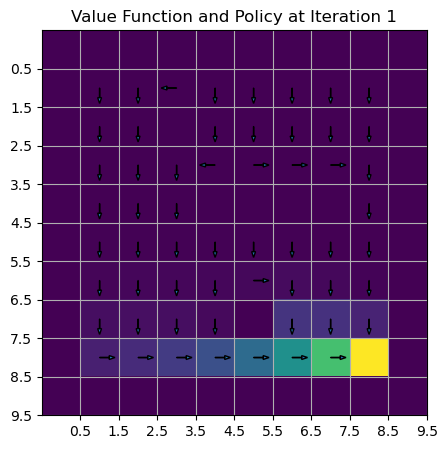

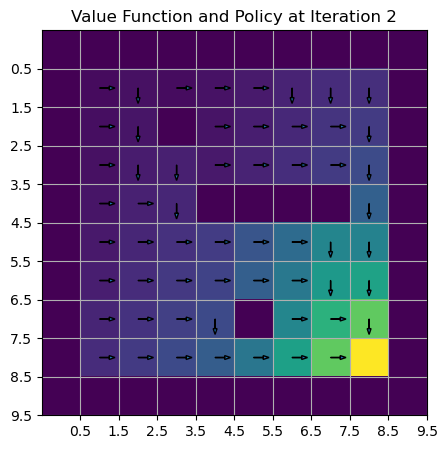

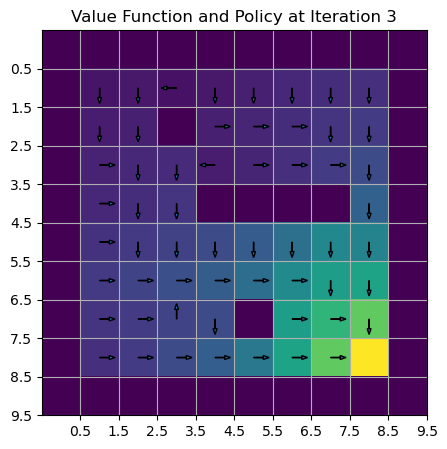

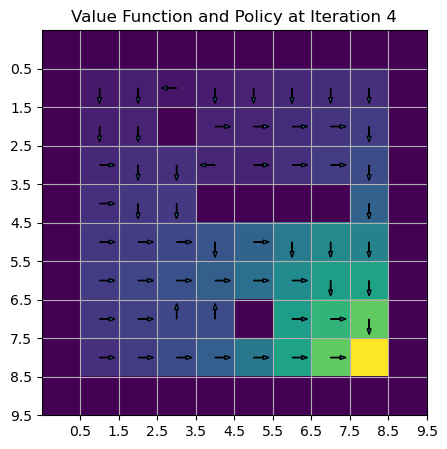

In [6]:

env = Environment()
grid = env.init_map()

0, 1, 2, 3  # left, right, up, down
obstacle_locs = np.where(grid == 1)
obstacle_positions = list(zip(*np.where(grid == 1)))
goal_position = list(zip(*np.where(grid == 2)))

transition_matrix = init_transitions(env, obstacle_positions, goal_position[0])
Q_values = init_Q(env, grid)

num_iterations = 4
V = np.zeros(env.grid_size)
policies = np.ones((num_iterations + 1, env.grid_size[0], env.grid_size[1]), dtype=int)

for i in range(num_iterations):
    updated_value_func = iter(env, 
        transition_matrix, Q_values, V, policies[i]
    )
    V = updated_value_func
    policies[i + 1] = policy_imp(env, 
        transition_matrix, Q_values, updated_value_func
    )
    plot(updated_value_func, policies[i + 1], i + 1, obstacle_positions, goal_position)